# Lab 04: Part 2 - The Bootstrap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model

## 1. Constructing confidence intervals via bootstrap

In [4]:
# From PTSD paper, there were 52 test cases, 42 of which were correct

n = 52
c = 42

# Create array of zeros, size n
rawdata = np.zeros(n)

# Set first c elements to 1
rawdata[range(c)] = 1

# Create pandas data frame
data = pd.DataFrame({"Match": rawdata})

In [5]:
# Compute 10000 bootstrap datasets, compute means in each

def createBootstrapMeans(data):
    numboot = 10000
    n = len(data)
    boot_means = np.zeros(numboot)
    np.random.seed(0)
    for i in range(numboot):
        d = data.sample(n, replace=True)
        boot_means[i] = d.mean()
    return boot_means

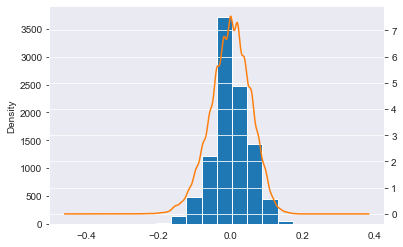

In [21]:
# #even though we are not using seaborn we can style the plots with it
sns.set_style("darkgrid") 

# Create a dataframe
bm = pd.DataFrame(data=createBootstrapMeans(data)-data.Match.mean(), columns=['samples'])

# Plot histogram and KDE
ax = bm.samples.plot(kind='hist')
bm.samples.plot(kind='kde', ax=ax, secondary_y=True)
plt.show()

In [22]:
# Compute quantiles
boot_quant = np.quantile(bm, [0.025, 0.975])
print(boot_quant)

[-0.11538462  0.09615385]


In [25]:
# Compute confidence interval
boot_ci = [data.Match.mean() - boot_quant[1], 
           data.Match.mean() - boot_quant[0]]
print("Boot ci:",boot_ci)


Boot ci: [0.7115384615384616, 0.9230769230769231]


## 2. Bootstrap of a regression model

## A. Building a linear model

In [27]:
# Data: 1000 births from North Carolina
# https://www.openintro.org/stat/data/?data=nc
# We are interested in the link between 
# Weeks: gestation time (length of the pregnancy in weeks) 
# Weigh: Birth weight im pounds
D = pd.read_csv("nc.csv")
D.head()

,fage,mage,mature,weeks,premie,visits,marital,gained,weight,lowbirthweight,gender,habit,whitemom
0,NaN,13,younger mom,39.0,full term,10.0,married,38.0,7.63,not low,male,nonsmoker,not white
1,NaN,14,younger mom,42.0,full term,15.0,married,20.0,7.88,not low,male,nonsmoker,not white
2,19.0,15,younger mom,37.0,full term,11.0,married,38.0,6.63,not low,female,nonsmoker,white
3,21.0,15,younger mom,41.0,full term,6.0,married,34.0,8.00,not low,male,nonsmoker,white
4,NaN,15,younger mom,39.0,full term,9.0,married,27.0,6.38,not low,female,nonsmoker,not white


In [28]:
# Check for missing data and exclude observations
print("Number of NaN:",sum(np.isnan(D.weeks)))
D = D[~np.isnan(D.weeks)]

Number of NaN: 2


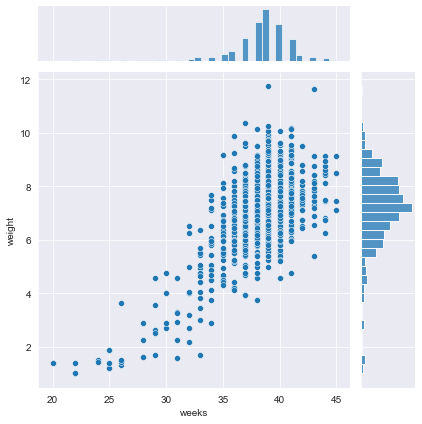

In [30]:
# Make a Joint plot between weeks and weight
sns.jointplot(data=D,x='weeks',y='weight')
plt.show()

In [31]:
# Train a model on the training set and plot the fit 
regr = sklearn.linear_model.LinearRegression()
X_fit = np.c_[D.weeks,D.weeks**2,D.weeks**3]
regr.fit(X_fit,D.weight)
regr.coef_

array([-5.21866875e+00,  1.78832738e-01, -1.85596626e-03])

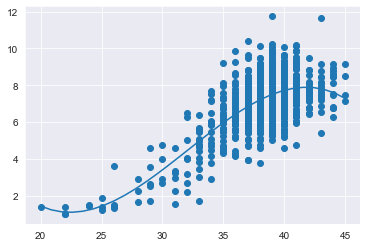

In [33]:
# Plot the Fit of model 
plt.scatter(D.weeks,D.weight)
p_weeks = np.linspace(20,45,30)
X_pred = np.c_[p_weeks,p_weeks**2,p_weeks**3]
p_weight=regr.predict(X_pred)
plt.plot(p_weeks,p_weight)
plt.show()

## 2. Bootstrap the model parameters

In [40]:
# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data):
    numboot = 1000
    n = len(data)
    theta = np.zeros((numboot,3))    
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.weeks,d.weeks**2,d.weeks**3]
        regr.fit(X_fit,d.weight)
        theta[i,:]=regr.coef_
    return theta

In [41]:
# Get 1000 Bootstrap fits
thetaBS = BootstrapCoef(D)

In [42]:
thetaBS

array([[-4.41585849e+00,  1.52903558e-01, -1.58495184e-03],
       [-5.82282478e+00,  1.97790971e-01, -2.04803379e-03],
       [-5.82827245e+00,  1.97977179e-01, -2.05075487e-03],
       ...,
       [-5.01092661e+00,  1.74122582e-01, -1.82539621e-03],
       [-5.44436904e+00,  1.87628478e-01, -1.96294274e-03],
       [-3.89366427e+00,  1.41103593e-01, -1.50250505e-03]])

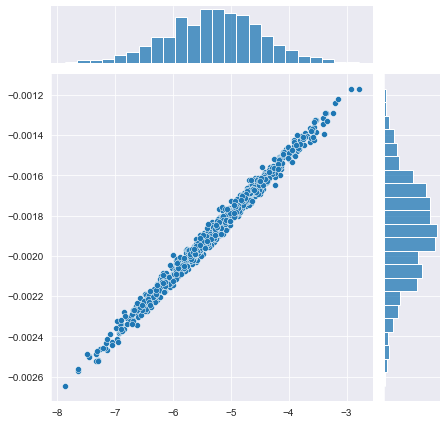

In [43]:
# Make a joint plot of two parameters 
sns.jointplot(x=thetaBS[:,0],y=thetaBS[:,2])
plt.show()

## 3. Bootstrap the model prediction

In [44]:
# Write a Bootstrap function that records the fitted models 
def BootstrapPred(data,xp):
    numboot = 1000
    n = len(data)
    X_pred = np.c_[xp,xp**2,xp**3]
    y_pred = np.zeros((numboot,X_pred.shape[0]))    

    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = np.c_[d.weeks,d.weeks**2,d.weeks**3]
        regr.fit(X_fit,d.weight)
        y_pred[i,:]=regr.predict(X_pred)
    return y_pred

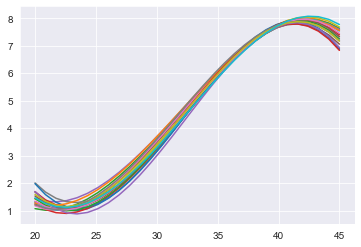

In [45]:
# Plot 20 of the bootstrapped predictions 
y_pred = BootstrapPred(D,p_weeks)

for i in range(20):
    plt.plot(p_weeks,y_pred[i,:])

[array([-0.74733251, -0.56994225, -0.41005966, -0.32452748, -0.26607735,
       -0.26551944, -0.28349861, -0.28960067, -0.29917347, -0.31162883,
       -0.3076032 , -0.2938343 , -0.27604274, -0.24574555, -0.22042557,
       -0.1933314 , -0.17176889, -0.14742677, -0.12095752, -0.099129  ,
       -0.08022129, -0.07459674, -0.07203385, -0.07183588, -0.08506943,
       -0.11841464, -0.17029371, -0.24312322, -0.32392186, -0.44318359]), array([0.66683901, 0.51430747, 0.39466071, 0.30601701, 0.26140526,
       0.251572  , 0.2768732 , 0.28867107, 0.29968388, 0.3008857 ,
       0.29962752, 0.28688676, 0.27603406, 0.25272037, 0.22605675,
       0.20116684, 0.16907325, 0.1374889 , 0.11268809, 0.09489767,
       0.08516746, 0.07835107, 0.07226359, 0.07016729, 0.07994549,
       0.11094378, 0.16199753, 0.23159372, 0.32873603, 0.44906669])]


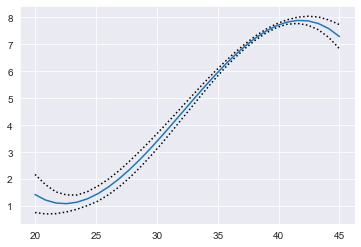

In [47]:
# Calculate upper and lower confidence bounds for prediction 
# From Bootstrapped means 
upper=np.quantile(y_pred-p_weight,0.975,axis=0)
lower=np.quantile(y_pred-p_weight,0.025,axis=0)

# Create the plot
plt.plot(p_weeks,p_weight)
plt.plot(p_weeks,p_weight-upper,'k:')
plt.plot(p_weeks,p_weight-lower,'k:')
plt.show()